# NSI Gas

### Imports

In [169]:
import warnings
import sys
import os.path
import math
sys.path.insert(0, os.path.abspath('../../../../functions'))
from knmi_weather import knmi_weather as knmi # eda tools
from sp_ql import Engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from math import ceil
import datetime as dt
import statistics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
import joblib
import seaborn as sns
import xgboost
from xgboost import XGBRegressor

### Defs

In [170]:
def calc_soc_pos_on_plot(df_compare_monthly, soc):
    sm = list(df_compare_monthly.index < soc).index(False) # first False is start month
    return sm - 0.5 # place of dashed line on plot in 0-1 x coord range

### Read inputs

In [177]:
project = 'NSI' #for NSI
engine=Engine(project=project, isAsync=False)
bms_registers = engine.list().filter(unit='CELCIUS').all()
build_names = bms_registers['keyname_01'].unique()
build_names = build_names[~pd.isna(build_names)]
eans=pd.read_csv(f'/Users/Matt/Desktop/MSc/Thesis/Spectral/brighter_eda/inputs/eans/{project.lower()}_eans.csv')

#extraction of unique keyname_01 and EAN for gas
gas_eans=eans[eans['Contract Type']=='Natural Gas']
gas_eans=gas_eans[['keyname_01', 'EAN']].dropna().set_index('keyname_01').squeeze()

#adds missing buildings
for building in build_names:
    if building not in gas_eans.index:
        gas_eans[building]=np.nan

#Derkinderenstraat
del gas_eans['FOKKERWG'] 
del gas_eans['PARI_ADM']
del gas_eans['ROME_ADM']
del gas_eans['P23584']
del gas_eans['RADPAMS'] # has heat EAN, no gas EANs
del gas_eans['R003331'] # has heat EAN, no gas EANs
del gas_eans['P163063']
del gas_eans['BENNEK43']
del gas_eans['P2639']
gas_eans = gas_eans.append(pd.Series(index=['P163063'],data=['871687140000067876']))

In [178]:
# determine building location
cities = eans[['keyname_01', 'City']].dropna()
cities = cities.drop_duplicates().set_index('keyname_01').squeeze()
cities['P163063']='Amsterdam' #manually adding: Derkinderenstraat=P163063=Amsterdam
cities = cities[gas_eans.index]

# read and preprocess weather data
knmi_station_lookup = pd.read_csv(r'../../../../inputs/knmi/knmi_uurgegevens/city_knmi_station_lookup.csv', index_col=0, squeeze=True)

In [179]:
knmi_station_lookup

city
Amsterdam                 240
Capelle aan den IJssel    344
Eindhoven                 370
Hoofddorp                 240
Utrecht                   260
Ede                       275
Name: knmi_station, dtype: int64

In [180]:
# read in start of control dates
socs = pd.read_csv(r'../../../../inputs/start_of_control/start_of_control_dates.csv')
socs = socs[socs['project']==project]
socs = socs.set_index('keyname_01')['soc_date'].squeeze()
socs = pd.to_datetime(socs)
socs

keyname_01
FOKKERWG   2021-10-18
BENNEK41   2021-10-21
RADPAMS    2019-11-27
R003331    2021-11-22
AVS_UTR    2021-10-19
P163063    2021-12-21
PARI_ADM   2021-12-15
P2639      2021-11-11
ROME_ADM   2021-12-15
DIEMEN     2021-10-26
Name: soc_date, dtype: datetime64[ns]

In [181]:
#removes two buildings from build_names which have both no electricity and gas EAN data
build_names=np.delete(build_names, 7, axis=None)

In [182]:
build_names

array(['RADPAMS', 'DIEMEN', 'FOKKERWG', 'BENNEK41', 'R003331', 'AVS_UTR',
       'BENNEK43', 'P2639', 'ROME_ADM', 'PARI_ADM', 'P23584'],
      dtype=object)

### Preprocess inputs

In [183]:
knmi_station_lookup.unique()

array([240, 344, 370, 260, 275])

In [184]:
weather = {}
for station in knmi_station_lookup.unique():
    knmi_weather_file_1 = f'../../../../inputs/knmi/knmi_uurgegevens/uurgeg_{station}_2011-2020.txt'
    knmi_weather_file_2 = f'../../../../inputs/knmi/knmi_uurgegevens/uurgeg_{station}_2021-2030.txt'
    knmi_weather = pd.read_csv(knmi_weather_file_1,
                               skiprows=31,
                               skipinitialspace=True,
                               usecols=list(range(1, 25)))
    knmi_weather = knmi_weather.append(pd.read_csv(knmi_weather_file_2,
                                                   skiprows=31,
                                                   skipinitialspace=True,
                                                   usecols=list(range(1, 25))))
    # making proper index for KNMI weather data
    knmi_weather.index = knmi.convert_knmi_dates(date=knmi_weather['YYYYMMDD'],
                                                 hour=knmi_weather['HH'])
    # clean up values
    knmi_weather = knmi.cleanup_knmi_units(knmi_weather=knmi_weather)
    weather[station] = knmi_weather

In [185]:
## Determine training and prediction intervals
train_periods = pd.DataFrame()
train_periods['end'] = socs[gas_eans.index]
train_periods['start'] = socs[gas_eans.index] - dt.timedelta(days=365) #more training data=better

In [186]:
train_periods

,end,start
AVS_UTR,2021-10-19,2020-10-19
BENNEK41,2021-10-21,2020-10-21
DIEMEN,2021-10-26,2020-10-26
P163063,2021-12-21,2020-12-21


### Get data from sp-ql

In [188]:
## prepare features and training data:
# get and save training gas use data locally (no need to do this every time)
engine = Engine(project=project, isAsync=False)
time_res = 'd'
gas_use_train = pd.DataFrame(index=pd.date_range(start=train_periods['start'].min(),
                                                 end=train_periods['end'].max(),
                                                 freq=time_res))

# data from sp-ql
for building in gas_eans.index:
    # get gas use
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    gas_ean = gas_eans[building]
    gas_use = engine.select(gas_ean).group_by(time_res).sum().after(start_train).before(end_train).all()
    gas_use = gas_use.rename(columns={gas_use.columns[0]:building})
    gas_use_train = gas_use_train.join(gas_use)
gas_use_train.to_csv(r'NSI_gas/data/gas_use_train.csv')

In [189]:
gas_use_train

,AVS_UTR,BENNEK41,DIEMEN,P163063
2020-10-19,236.741806,NaN,NaN,NaN
2020-10-20,161.764099,NaN,NaN,NaN
2020-10-21,87.298500,96.305298,NaN,NaN
2020-10-22,90.200203,97.219002,NaN,NaN
2020-10-23,116.458099,121.388199,NaN,NaN
...,...,...,...,...
2021-12-17,NaN,NaN,NaN,205.644302
2021-12-18,NaN,NaN,NaN,115.875702
2021-12-19,NaN,NaN,NaN,141.581100
2021-12-20,NaN,NaN,NaN,395.925110


In [190]:
gas_use_train = pd.read_csv(r'NSI_gas/data/gas_use_train.csv', index_col=0,
                            parse_dates=True)

In [191]:
# some buildings have small gaps in gas data. We can interpolate over these
for building in gas_eans.index:
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    gas_use_train_build = gas_use_train.loc[start_train:end_train, building]
    # setting first element to 0 if nan. To aid interpolation.
    if gas_use_train_build.iloc[[0]].isna()[0]:
        gas_use_train_build.iloc[0] = 0
    gas_use_train_build = gas_use_train_build.interpolate(limit=10) # filling max 10 consecutive days of missing data
    gas_use_train.loc[start_train:end_train, building] = gas_use_train_build
gas_use_train

,AVS_UTR,BENNEK41,DIEMEN,P163063
2020-10-19,236.741806,NaN,NaN,NaN
2020-10-20,161.764099,NaN,NaN,NaN
2020-10-21,87.298500,96.305298,NaN,NaN
2020-10-22,90.200203,97.219002,NaN,NaN
2020-10-23,116.458099,121.388199,NaN,NaN
...,...,...,...,...
2021-12-17,NaN,NaN,NaN,205.644302
2021-12-18,NaN,NaN,NaN,115.875702
2021-12-19,NaN,NaN,NaN,141.581100
2021-12-20,NaN,NaN,NaN,395.925110


### RF model

In [192]:
# train and save building energy use RF models
for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    #
    features = pd.DataFrame()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek
    #features['month'] = features.index.month
    #
    gas_use_train_build = gas_use_train[building]
    # X: training features, y: training target
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]
    #
    # checking if there is any nan in the data
    if X.isna().sum().sum() + y.isna().sum() > 0:
        raise ValueError('NaN in training data:', building)
    #
    # checking on dependency of taget on features to get a feel
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    #
    # make train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #
    # grid-search for hyper parameter tuning
    param_grid = {'max_depth': [2, 5, 10, 20, 50, 100],
                  'min_samples_leaf': [1, 5, 10],
                  'n_estimators': [500]}
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False) # cv --> Kfold 10 with shuffle - because my data is in order (if I would randomize the order then this would not be necessary)
    grid_search.fit(X_train, y_train)
    #
    # save the trained RF
    joblib.dump(grid_search.best_estimator_, fr'NSI_gas/data/trained_models/rf/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_gas/data/trained_models/rf/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_gas/data/trained_models/rf/y_test_{building}.joblib')

Training building AVS_UTR, 1/4
Training building BENNEK41, 2/4
Training building DIEMEN, 3/4
Training building P163063, 4/4


### Gradient Boosting

In [193]:
for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    #
    features = pd.DataFrame()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek
    #features['month'] = features.index.month
    #
    gas_use_train_build = gas_use_train[building]
    # X: training features, y: training target
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]
    #
    # checking if there is any nan in the data
    if X.isna().sum().sum() + y.isna().sum() > 0:
        raise ValueError('NaN in training data:', building)
    #
    # checking on dependency of taget on features to get a feel
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    #
    # make train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #
    # grid-search for hyper parameter tuning
    param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10],
    }
    
    rf = GradientBoostingRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)
    #
    # save the trained RF
    joblib.dump(grid_search.best_estimator_, fr'NSI_gas/data/trained_models/gb/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_gas/data/trained_models/gb/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_gas/data/trained_models/gb/y_test_{building}.joblib')

Training building AVS_UTR, 1/4
Training building BENNEK41, 2/4
Training building DIEMEN, 3/4
Training building P163063, 4/4


### XGBoosting

In [194]:
for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    features = pd.DataFrame()
    
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek

    gas_use_train_build = gas_use_train[building]
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    
    param_grid={
                "learning_rate": (0.05, 0.10, 0.15, 0.2),
                "max_depth": [3, 4, 5, 6, 8],
                "min_child_weight": [1, 3, 5, 7]
                }

    rf = XGBRegressor()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=cv, n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)

    joblib.dump(grid_search.best_estimator_, fr'NSI_gas/data/trained_models/xg/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_gas/data/trained_models/xg/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_gas/data/trained_models/xg/y_test_{building}.joblib')

Training building AVS_UTR, 1/4
Training building BENNEK41, 2/4
Training building DIEMEN, 3/4
Training building P163063, 4/4


### Metrics

In [266]:
# reading in saved trained RF models and calculating mae for the test set
mae_range_percent = pd.Series()
for building in gas_eans.index:
    models = os.listdir('NSI_gas/data/trained_models/rf') #change for RF, GB, XG
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'NSI_gas/data/trained_models/rf/trained_{building}.joblib') #change for RF, GB, XG
        X_test = joblib.load(fr'NSI_gas/data/trained_models/rf/X_test_{building}.joblib') #change for RF, GB, XG
        y_test = joblib.load(fr'NSI_gas/data/trained_models/rf/y_test_{building}.joblib') #change for RF, GB, XG
    #
    # grid search already contains the re-trained model with the best parameters
    y_test_pred = grid_search.predict(X_test)
    #
    # calculating MAE and plotting test and pred_test
    mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    # mae in percent of range
    mae_range_percent[building] = mae / y_test.max() * 100
    
    gas_use_train_build = gas_use_train[building]

In [267]:
statistics.mean(mae_range_percent)

4.623516577538056

In [268]:
mae_range_percent

AVS_UTR     3.844842
BENNEK41    5.095024
DIEMEN      4.167899
P163063     5.386301
dtype: float64

### Metrics together - MAE

In [269]:
metric_com_mae = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    mae_range_percent = pd.Series()
    for building in gas_eans.index:
        models = os.listdir(f'NSI_gas/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)

        #
        # calculating MAE and plotting test and pred_test
        mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
        # mae in percent of range
        mae_range_percent[building] = mae / y_test.max() * 100

        gas_use_train_build = gas_eans[building]

    metric_com_mae[regressor.upper()]=mae_range_percent

### Metrics together - RMSE

In [270]:
metric_com_rmse = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    rmse_range_percent = pd.Series()
    for building in gas_eans.index:
        models = os.listdir(f'NSI_gas/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)
        
        #calculating RMSE
        MSE = np.square(np.subtract(y_test, y_test_pred)).mean() 
        RMSE = math.sqrt(MSE)
        rmse_range_percent[building]=RMSE / y_test.max() * 100

    metric_com_rmse[regressor.upper()]=rmse_range_percent

### Stacked ensembling - MAE

In [271]:
en_mae = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
mae_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in gas_eans.index:
    for regressor in regressors:
        models = os.listdir(f'NSI_gas/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]

    mae = mean_absolute_error(y_true=df_c[building+"_en"], y_pred=df_d[building+"_en"])
    
    mae_range_percent[building] = mae / df_c[building+"_en"].max() * 100

    en_mae['EN']=mae_range_percent
    
print(en_mae)

                EN
AVS_UTR   4.692415
BENNEK41  4.958518
DIEMEN    4.810381
P163063   5.117558


In [272]:
en_mae.mean()

EN    4.894718
dtype: float64

### Ensemble stacked - MAE

In [273]:
metric_com_mae['EN']=en_mae
print(metric_com_mae)
print("\n")
print("Average MAEs")
round(metric_com_mae.mean(), 5)

                RF        GB        XG        EN
AVS_UTR   3.844842  6.836982  5.229777  4.692415
BENNEK41  5.095024  6.689696  5.762182  4.958518
DIEMEN    4.167899  7.075229  4.994513  4.810381
P163063   5.386301  8.025832  5.017156  5.117558


Average MAEs


RF    4.62352
GB    7.15693
XG    5.25091
EN    4.89472
dtype: float64

### Stacked ensembling - RMSE

In [274]:
en_rmse = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
rmse_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in gas_eans.index:
    for regressor in regressors:
        models = os.listdir(f'NSI_gas/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_gas/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    

    MSE = np.square(np.subtract(df_c[building+"_en"], df_d[building+"_en"])).mean() 
    RMSE = math.sqrt(MSE)
    rmse_range_percent[building]=RMSE / df_c[building+"_en"].max() * 100
    
    en_rmse['EN']=rmse_range_percent
    

### Ensemble effort - RMSE

In [275]:
metric_com_rmse['EN']=en_rmse
print(metric_com_rmse)
print("\n")
print("Average RMSEs")
round(metric_com_rmse.mean(), 5)

                RF         GB        XG        EN
AVS_UTR   6.138280  10.272332  8.453117  6.313724
BENNEK41  7.843562  10.878739  8.747678  6.678695
DIEMEN    6.482868   9.183875  7.760370  6.066347
P163063   8.764649  10.823812  7.805544  6.682594


Average RMSEs


RF     7.30734
GB    10.28969
XG     8.19168
EN     6.43534
dtype: float64

# All models

### Adding ensemble predictions

In [276]:
gas_use_pred = pd.DataFrame(index=features.index)
for m in ['rf','gb','xg']:
    for building in gas_eans.index:
        # select weather data for prediction
        city = cities[building]
        knmi_station = knmi_station_lookup[city]
        knmi_weather = weather[knmi_station]
        # preapare features for prediction
        features = pd.DataFrame()
        features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
        features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
        features['dow'] = features.index.dayofweek
        #features['month'] = features.index.month
        X_pred = features
        # do the predictions
        models = os.listdir(f'NSI_gas/data/trained_models/{m}')
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_gas/data/trained_models/{m}/trained_{building}.joblib')
        y_pred = grid_search.predict(X_pred)
        gas_use_pred[building+'_'+m] = y_pred

In [277]:
#ensemble stacking, equal weight
gas_use_pred['AVS_UTR_en']=(gas_use_pred['AVS_UTR_rf']+gas_use_pred['AVS_UTR_gb']+gas_use_pred['AVS_UTR_xg'])/3
gas_use_pred['BENNEK41_en']=(gas_use_pred['BENNEK41_rf']+gas_use_pred['BENNEK41_gb']+gas_use_pred['BENNEK41_xg'])/3
gas_use_pred['DIEMEN_en']=(gas_use_pred['DIEMEN_rf']+gas_use_pred['DIEMEN_gb']+gas_use_pred['DIEMEN_xg'])/3
gas_use_pred['P163063_en']=(gas_use_pred['P163063_rf']+gas_use_pred['P163063_gb']+gas_use_pred['P163063_xg'])/3

In [278]:
# compare predicted and measured gas use after start of control
engine = Engine(project=project, isAsync=False)
time_res = 'd'
gas_use_meas = pd.DataFrame(index=pd.date_range(start=train_periods['start'].min(),
                                                 end=knmi_weather.index[-1],
                                                 freq=time_res))
for building in gas_eans.index:
    # get gas use
    start = train_periods['start'].min()
    end = knmi_weather.index[-1]
    gas_ean = gas_eans[building]
    gas_use = engine.select(gas_ean).group_by(time_res).sum().after(start).before(end).all()
    gas_use = gas_use.rename(columns={gas_use.columns[0]:building})
    gas_use_meas = gas_use_meas.join(gas_use)

In [279]:
gas_use_meas.columns

Index(['AVS_UTR', 'BENNEK41', 'DIEMEN', 'P163063'], dtype='object')

In [280]:
gas_use_meas.rename(columns = {'AVS_UTR':'AVS_UTR_rf', 'BENNEK41':'BENNEK41_rf',
                                     'DIEMEN':'DIEMEN_rf', 'P163063':'P163063_rf'}, inplace = True)

In [281]:
for m in ['gb','xg']:
    for building in gas_eans.index:
        gas_use_meas[building+"_"+m]=gas_use_meas[building+"_rf"]

In [282]:
month_savings = {}
month_savings_m3 = {}
total_savings_perc = pd.Series()
total_savings_m3 = pd.Series()

for m in ['rf','gb','xg']:
    for building in gas_use_meas.columns:
        size = len(building)
        start = train_periods.loc[building[:size-3], 'start']
        end = knmi_weather.index[-1]
        soc = socs[building[:size-3]]
        gas_use_meas_m = gas_use_meas.loc[start:end, building].resample('d').sum()
        gas_use_pred_m = gas_use_pred.loc[start:end, building].resample('d').sum()
        month_saving = (gas_use_pred_m - gas_use_meas_m) / gas_use_pred_m * 100
        month_savings[building] = month_saving
        month_savings_m3[building] = gas_use_pred_m - gas_use_meas_m
        total_savings_m3[building] = (gas_use_pred.loc[soc:, building] - gas_use_meas.loc[soc:, building]).sum()
        total_savings_perc[building] = total_savings_m3[building] / gas_use_pred.loc[soc:, building].sum() * 100

train_pred_mae = pd.Series()
for m in ['rf','gb','xg']:
    for building in gas_use_meas.columns:
        size = len(building)
        soc = socs[building[:size-3]]
        start = train_periods.loc[building[:size-3], 'start']
        end = train_periods.loc[building[:size-3], 'end'] #knmi_weather.index[-1]
        gas_use_meas_m = gas_use_meas.loc[start:end, building].resample('d').sum()
        gas_use_pred_m = gas_use_pred.loc[start:end, building].resample('d').sum()
        gas_use_month_mae = mean_absolute_error(y_true=gas_use_meas_m, y_pred=gas_use_pred_m)
        train_pred_mae[building] = gas_use_month_mae

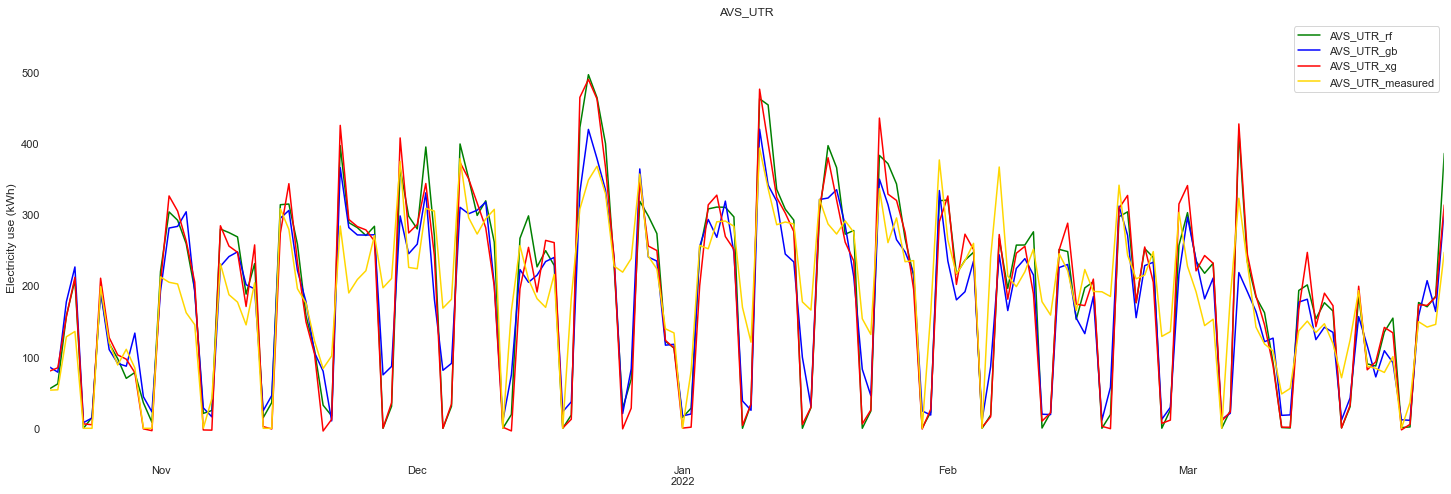

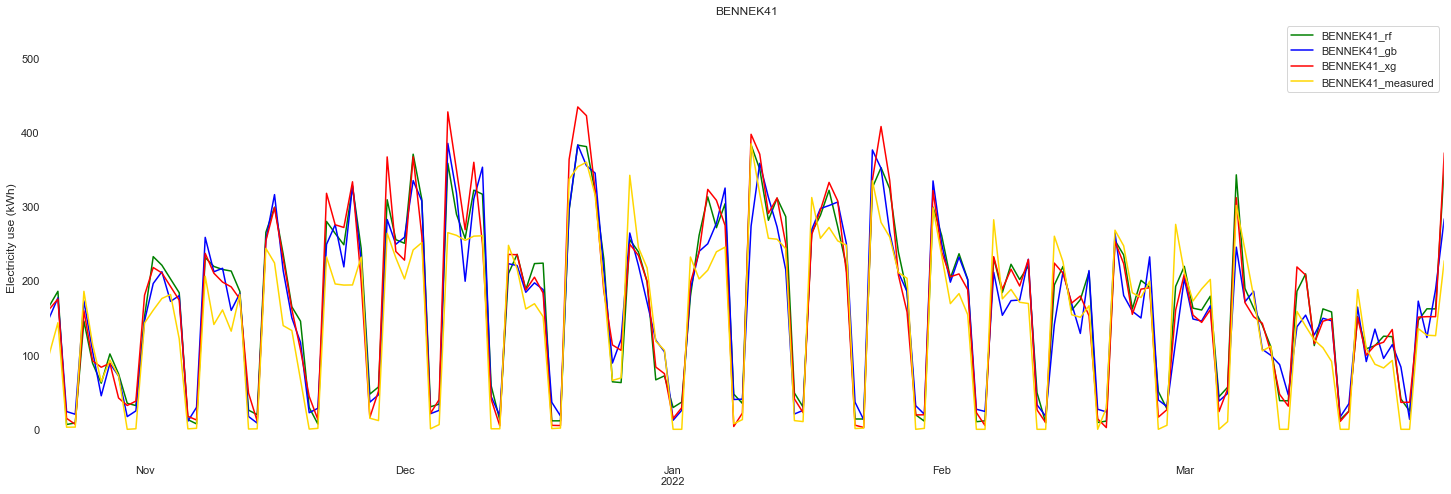

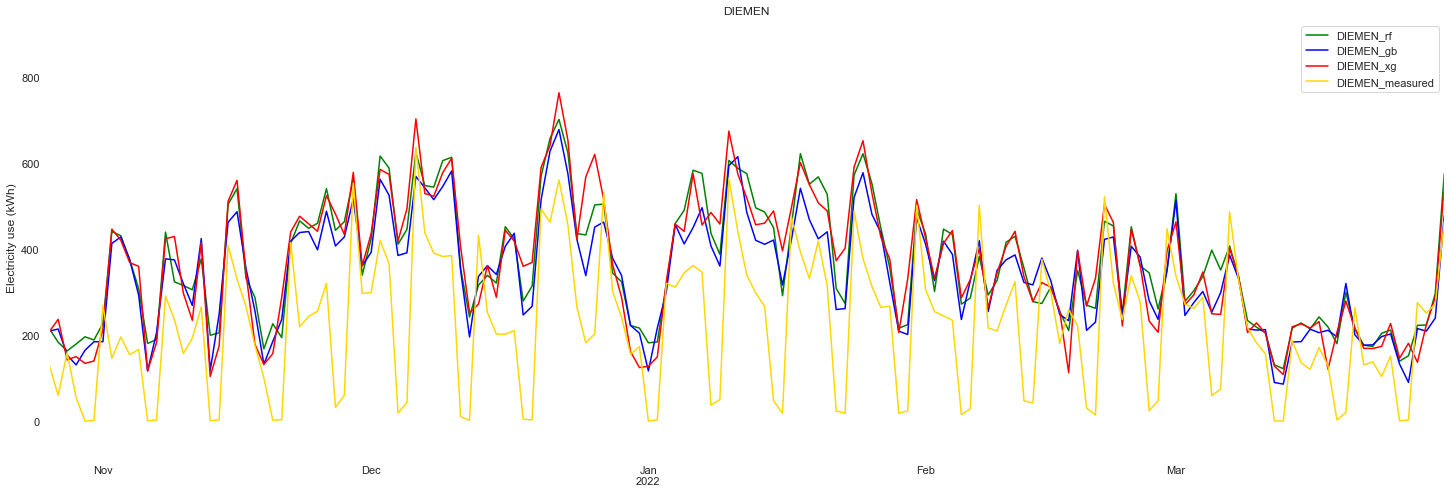

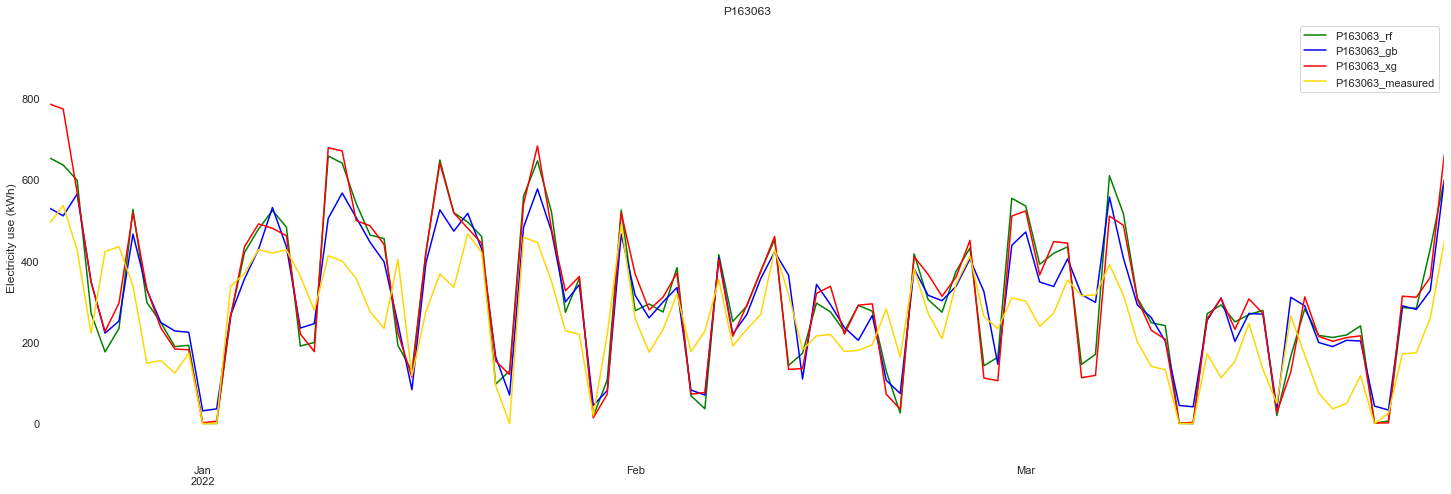

In [283]:
for building in gas_eans.index:
    t=pd.DataFrame()
    fig, ax = plt.subplots(figsize=(25, 8))
    gas_use_pred[building+"_rf"].plot(ax=ax, color='green')
    gas_use_pred[building+"_gb"].plot(ax=ax, color='blue')
    gas_use_pred[building+"_xg"].plot(ax=ax, color='red')
    t[building+"_measured"]=gas_use_meas[building+"_rf"]
    t.plot(ax=ax, color='gold')
    #electr_use_pred_en[building].plot(ax=ax, color='black')
    ax.set_xlim(left=gas_use_train[building].dropna().index[0])
    ax.set_title(building)
    ax.set_ylabel('Electricity use (kWh)')
    ax.legend()
    ax.axvline(x=socs[building], color='k', ls='--')
    plt.show(block=False)

### Comparison of individual models

In [296]:
gas_use_pred = pd.DataFrame(index=features.index)
for building in gas_eans.index:
    # select weather data for prediction
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    # preapare features for prediction
    features = pd.DataFrame()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek
    #features['month'] = features.index.month
    X_pred = features
    # do the predictions
    models = os.listdir('NSI_gas/data/trained_models/xg') #change for RF, GB, XG
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'NSI_gas/data/trained_models/xg/trained_{building}.joblib') #change for RF, GB, XG
    y_pred = grid_search.predict(X_pred)
    gas_use_pred[building] = y_pred

# Checking results and validating savings

In [297]:
# compare predicted and measured gas use after start of control
engine = Engine(project=project, isAsync=False)
time_res = 'd'
gas_use_meas = pd.DataFrame(index=pd.date_range(start=train_periods['start'].min(),
                                                 end=knmi_weather.index[-1],
                                                 freq=time_res))
for building in gas_eans.index:
    # get gas use
    start = train_periods['start'].min()
    end = knmi_weather.index[-1]
    gas_ean = gas_eans[building]
    gas_use = engine.select(gas_ean).group_by(time_res).sum().after(start).before(end).all()
    gas_use = gas_use.rename(columns={gas_use.columns[0]:building})
    gas_use_meas = gas_use_meas.join(gas_use)

In [298]:
gas_use_meas

,AVS_UTR,BENNEK41,DIEMEN,P163063
2020-10-19,236.741806,206.407501,333.770203,488.505310
2020-10-20,161.764099,163.752304,293.303894,403.556305
2020-10-21,87.298500,96.305298,186.565903,302.140198
2020-10-22,90.200203,97.219002,195.502594,314.591187
2020-10-23,116.458099,121.388199,213.978394,299.730286
...,...,...,...,...
2022-03-27,36.329102,0.000000,4.920300,25.805901
2022-03-28,149.824997,135.827393,277.639709,171.704697
2022-03-29,142.274200,126.870796,253.139008,174.616898
2022-03-30,146.119705,126.258202,275.330200,260.871094


In [299]:
# calculate savings
# saving = (pred - meas)/pred
# storing in a dict, because each building has different number of months
month_savings = {}
month_savings_m3 = {}
total_savings_perc = pd.Series()
total_savings_m3 = pd.Series()
for building in gas_eans.index:
    #building = 'GPR_EH'
    start = train_periods.loc[building, 'start']
    end = knmi_weather.index[-1]
    soc = socs[building]
    # monthly savings (including the training preiod where savings should be ~0)
    gas_use_meas_m = gas_use_meas.loc[start:end, building].resample('m').sum()
    gas_use_pred_m = gas_use_pred.loc[start:end, building].resample('m').sum()
    month_saving = (gas_use_pred_m - gas_use_meas_m) / gas_use_pred_m * 100
    month_savings[building] = month_saving
    month_savings_m3[building] = gas_use_pred_m - gas_use_meas_m
    # total savings after SOC
    total_savings_m3[building] = (gas_use_pred.loc[soc:, building] - gas_use_meas.loc[soc:, building]).sum()
    total_savings_perc[building] = total_savings_m3[building] / gas_use_pred.loc[soc:, building].sum() * 100

# calculate prediction error for error bars
train_pred_mae = pd.Series()
for building in gas_eans.index:
    soc = socs[building]
    start = train_periods.loc[building, 'start']
    end = train_periods.loc[building, 'end'] #knmi_weather.index[-1]
    gas_use_meas_m = gas_use_meas.loc[start:end, building].resample('m').sum()
    gas_use_pred_m = gas_use_pred.loc[start:end, building].resample('m').sum()
    #soc_pos = calc_soc_pos_on_plot(df_compare_monthly=gas_use_meas_m, soc=soc)
    #gas_use_meas_m = gas_use_meas_m.iloc[:int(soc_pos)]
    #gas_use_pred_m = gas_use_pred_m.iloc[:int(soc_pos)]
    gas_use_month_mae = mean_absolute_error(y_true=gas_use_meas_m, y_pred=gas_use_pred_m)
    #train_pred_error = (gas_use_pred_m - gas_use_meas_m) / gas_use_pred_m * 100
    train_pred_mae[building] = gas_use_month_mae

In [300]:
total_savings_m3

AVS_UTR     -1067.092774
BENNEK41     3555.247253
DIEMEN      22336.910990
P163063      6117.814034
dtype: float64

In [301]:
for building in gas_eans.index:
    total_savings_m3[building] = (gas_use_pred.loc[soc:, building] - gas_use_meas.loc[soc:, building]).sum()
    total_savings_perc[building] = ((gas_use_pred.loc[soc:, building] - gas_use_meas.loc[soc:, building]).sum() / gas_use_pred.loc[soc:, building].sum()) * 100
total_savings_perc

AVS_UTR     -7.503506
BENNEK41     8.366597
DIEMEN      35.466050
P163063     19.297860
dtype: float64

### Barplots with savings validation

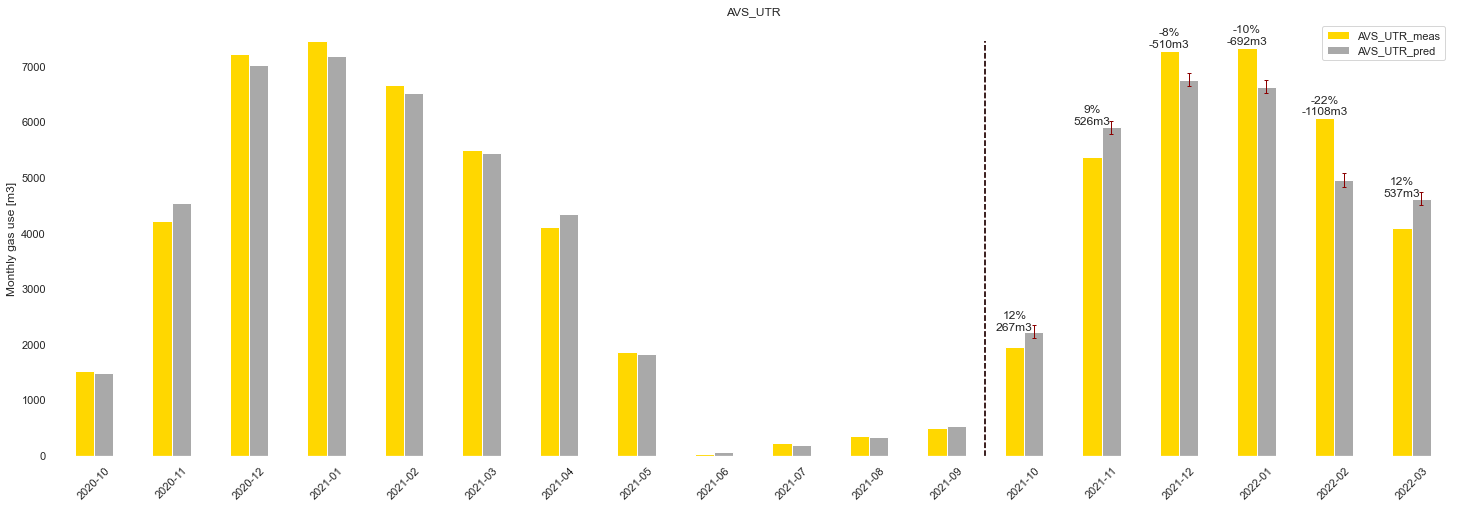

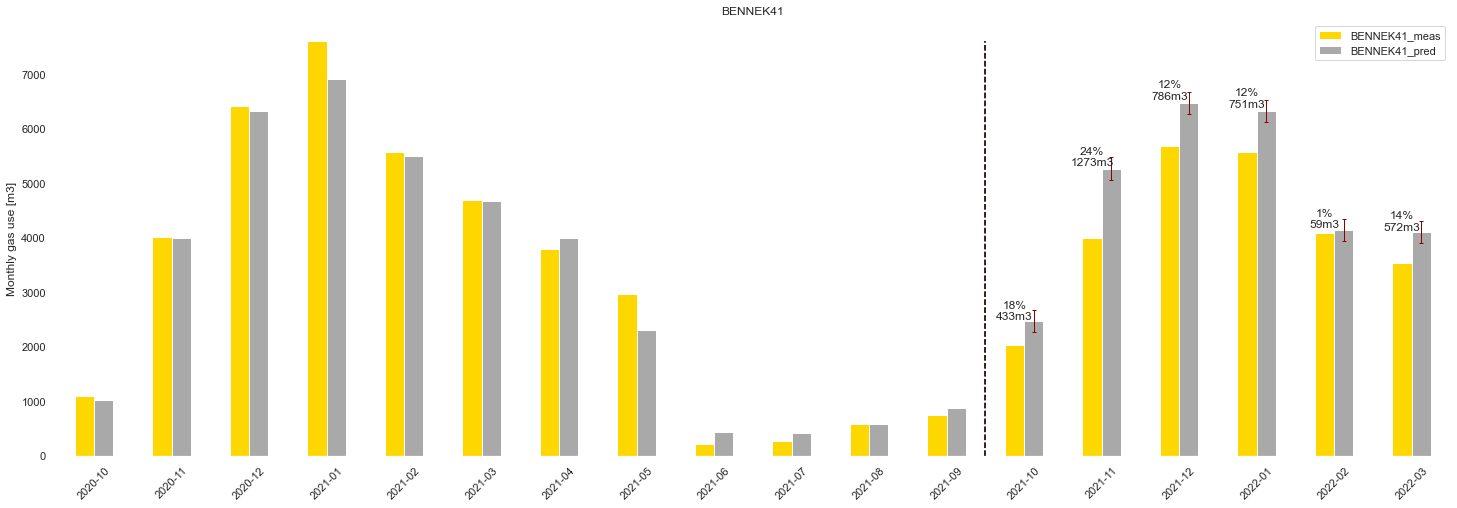

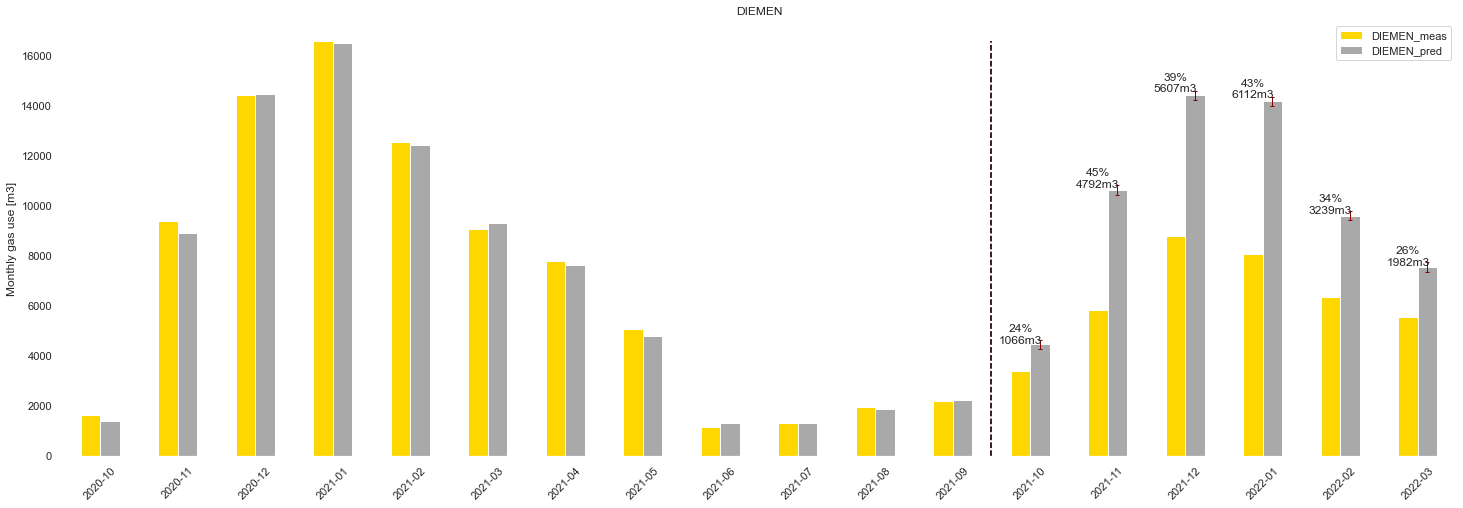

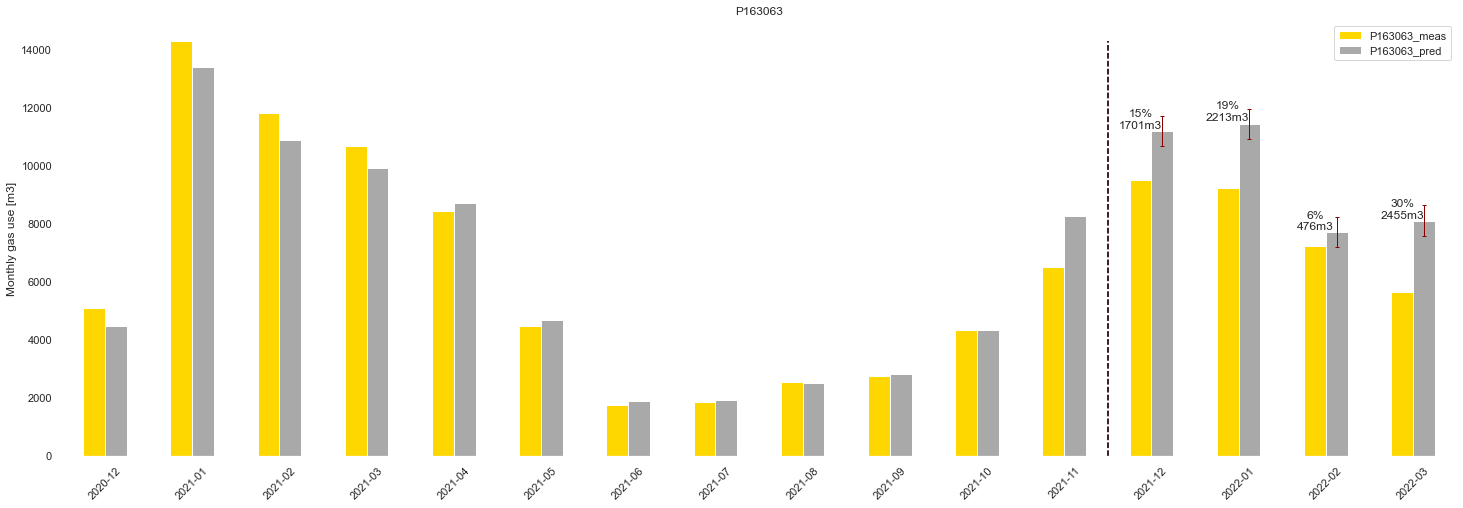

In [302]:
for building in gas_eans.index:
    start = train_periods.loc[building, 'start']
    end = knmi_weather.index[-1]
    df_compare = pd.DataFrame(index=pd.date_range(start=start,
                                                     end=end,
                                                     freq=time_res))
    df_compare = df_compare.join(gas_use_meas[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    df_compare = df_compare.join(gas_use_pred[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_pred'})
    #
    df_compare = df_compare.resample('m').sum()
    soc = socs[building]#.date()
    soc_pos = calc_soc_pos_on_plot(df_compare_monthly=df_compare, soc=soc)
    train_end_pos = calc_soc_pos_on_plot(df_compare_monthly=df_compare, soc=train_periods.loc[building, 'end'])
    #
    fig, ax = plt.subplots(figsize=(25, 8))
    err = pd.DataFrame(index=df_compare.index, data={fr'{building}_pred':train_pred_mae[building]})
    err.iloc[:int(soc_pos) + 1] = np.nan
    df_compare.plot.bar(ax=ax, color=['gold', 'darkgray'], yerr=err,
                        error_kw=dict(ecolor='darkred', lw=1, capsize=2, capthick=1))
    #soc_mark = pd.Series(index=df_compare.index, data=np.nan)
    ax.set_xticklabels([x.strftime("%Y-%m") for x in df_compare.index], rotation=45)
    plt.vlines(x=train_end_pos, ymin=0, ymax=df_compare.max().max(), color='darkred', ls='--')
    plt.vlines(x=soc_pos, ymin=0, ymax=df_compare.max().max(), color='k', ls='--')
    # adding saving % text
    patches = ax.patches
    patches_m = patches[0:int(len(patches)/2)]
    patches_p = patches[int(len(patches)/2):]
    for i, p in enumerate(patches[0:int(len(patches)/2)]):
        if i > soc_pos:
            saving = int(month_savings[building].iloc[i].round(0))
            saving_m3 = int(month_savings_m3[building].iloc[i].round(0))
            width = p.get_width()
            height = max(p.get_height(), patches_p[i].get_height())
            x, y = p.get_xy()
            ax.annotate(f'{saving}%\n{saving_m3}m3', (x + width/2, y + height*1.01), ha='center')
    #
    plt.ylabel('Monthly gas use [m3]')
    plt.title(building)
    plt.show(block=False)

In [323]:
# calculate monthly portfolio savings
gas_use_pred_sav = gas_use_pred
gas_use_meas_sav = gas_use_meas
for building in gas_eans.index:
    gas_use_pred_sav.loc[gas_use_pred_sav.index[0]:socs[building], building] = np.nan
    gas_use_meas_sav.loc[gas_use_meas_sav.index[0]:socs[building], building] = np.nan
gas_use_sav = gas_use_pred_sav - gas_use_meas_sav
gas_use_sav = gas_use_sav.resample('m').sum()
gas_use_sav = gas_use_sav.loc[socs[gas_eans.index].min():]

In [329]:
round(gas_use_sav.sum(),2)

AVS_UTR     -1093.72
BENNEK41     3494.49
DIEMEN      22259.45
P163063      5822.35
dtype: float64

In [330]:
round(gas_use_sav.sum().sum(),2)

30482.57

In [332]:
round(gas_use_sav.sum().sum()*0.87,2)

26519.84

In [327]:
for building in gas_use_sav.columns:
    print(building, "total savings since SOC (m3):", round(gas_use_sav[building].sum(),2))

AVS_UTR total savings since SOC (m3): -1093.72
BENNEK41 total savings since SOC (m3): 3494.49
DIEMEN total savings since SOC (m3): 22259.45
P163063 total savings since SOC (m3): 5822.35


### Plot portfolio savings

In [308]:
#fig, ax = plt.subplots(figsize=(25, 8))
#gas_use_sav.plot.barh(ax=ax, stacked=True, colormap='nipy_spectral')
#ax.set_yticklabels([x.strftime("%Y-%m") for x in gas_use_sav.index], rotation=45)
#ax.set_xlabel('Gas savings (m3)')
#plt.show(block=False)

### Plot overal savings per building from SOC

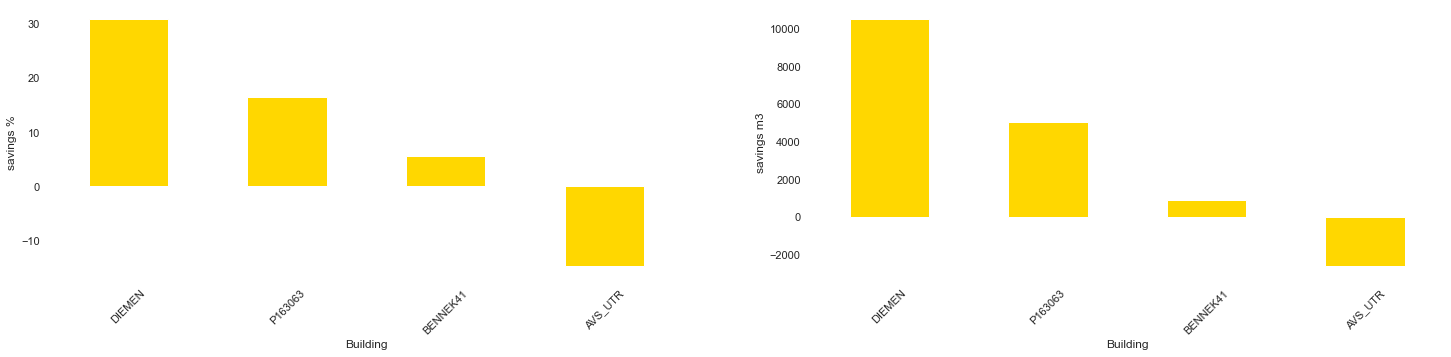

In [227]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 5))
for col, ax in zip(sorted(total_savings_plot_df.columns), axs.ravel()):
    total_savings_plot_df[col].plot.bar(ax=ax, color=['gold'])
    ax.set_xticklabels([x for x in total_savings_plot_df.index], rotation=45)
    ax.set_xlabel('Building')
    ax.set_ylabel(col)
plt.show(block=False)

### Per building gas use plots to spot missing data

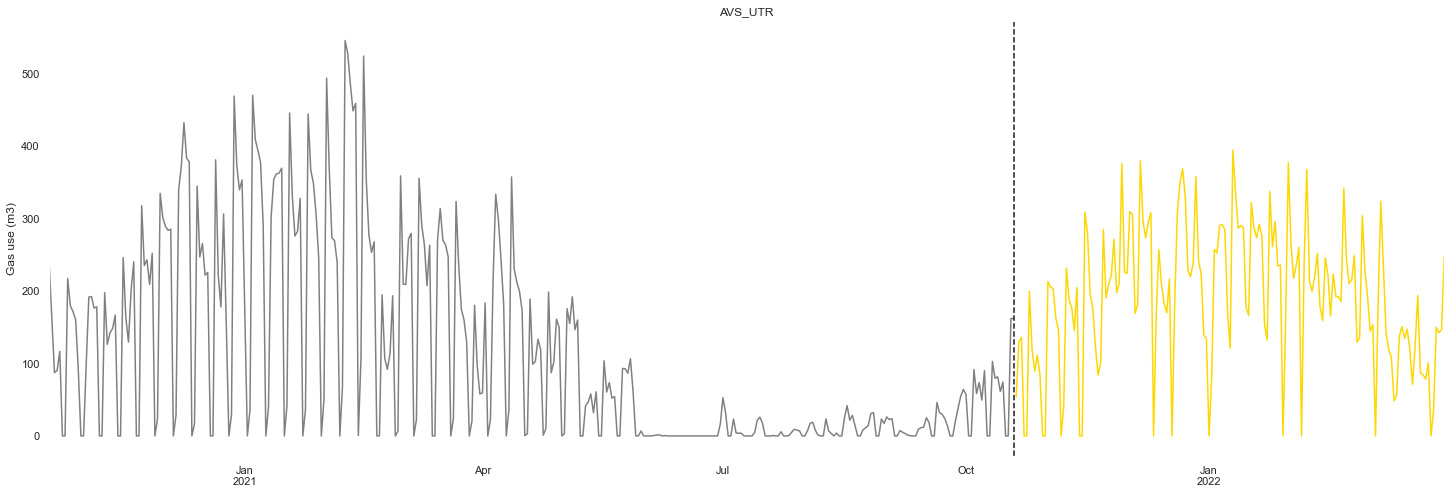

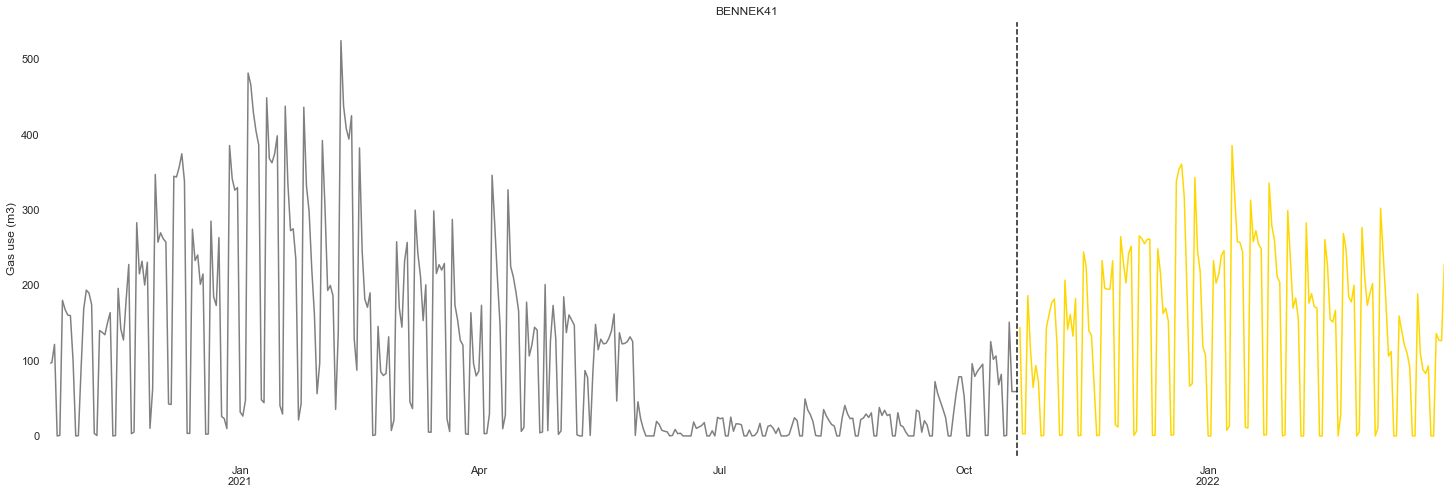

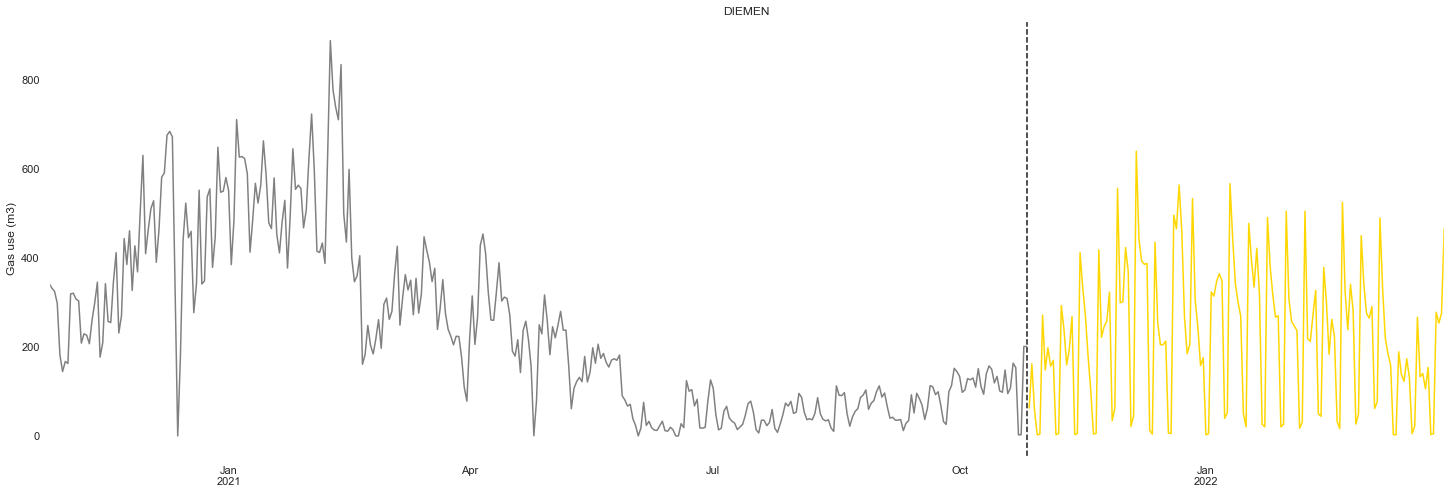

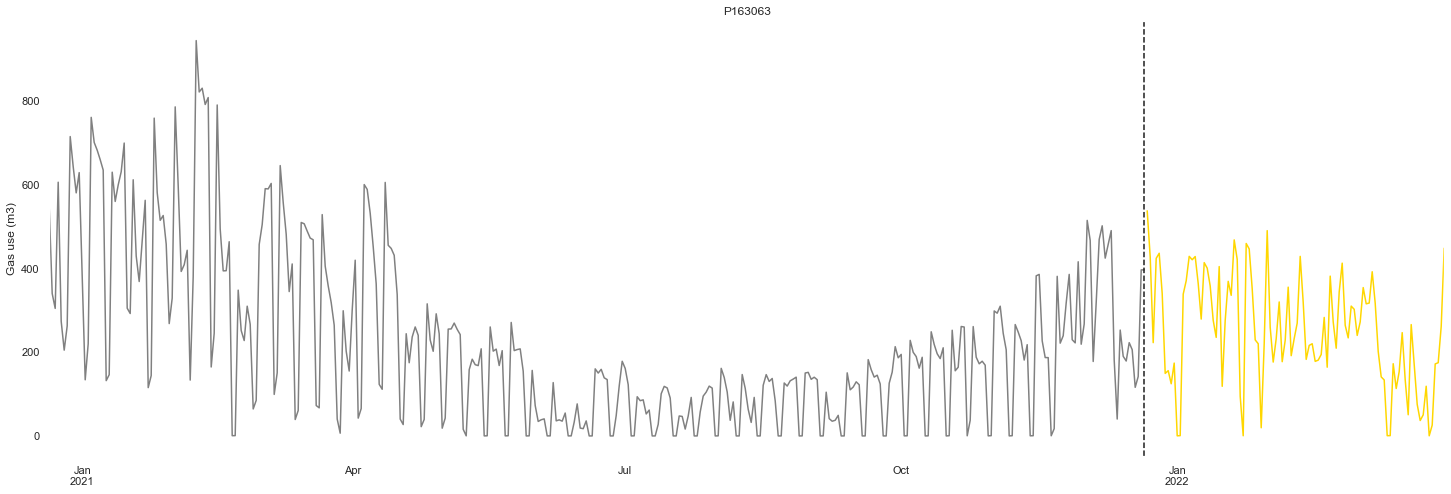

In [228]:
for building in gas_eans.index:
    fig, ax = plt.subplots(figsize=(25, 8))
    gas_use_train[building].plot(ax=ax, color='gray')
    gas_use_meas[building].plot(ax=ax, color='gold')
    ax.set_xlim(left=gas_use_train[building].dropna().index[0])
    ax.set_title(building)
    ax.set_ylabel('Gas use (m3)')
    ax.axvline(x=socs[building], color='k', ls='--')
    plt.show(block=False)

### Total Portflio Savings

In [253]:
total_savings_plot_df['m3_cost']=0.87
total_savings_plot_df['savings EUR']=total_savings_plot_df['savings m3']*total_savings_plot_df['m3_cost']
total_savings_plot_df['savings EUR']

DIEMEN      9136.387852
P163063     4375.933802
BENNEK41     793.311092
AVS_UTR    -2273.505158
Name: savings EUR, dtype: float64

Text(0, 0.5, 'Savings EUR')

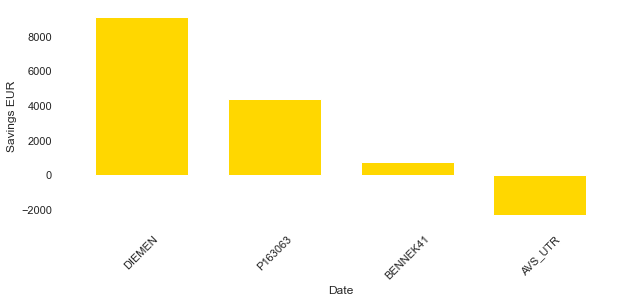

In [254]:
ax=total_savings_plot_df['savings EUR']
ax.plot.bar(figsize=(10,4), color='gold', width=0.7)
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Savings EUR")

In [255]:
total_savings_plot_df

,savings %,savings m3,m3_cost,savings EUR
DIEMEN,30.872134,10501.595233,0.87,9136.387852
P163063,16.429751,5029.808968,0.87,4375.933802
BENNEK41,5.534613,911.851830,0.87,793.311092
AVS_UTR,-14.780021,-2613.224319,0.87,-2273.505158


In [256]:
saved=total_savings_plot_df['savings EUR'].sum()
print("Client",project,"saves",round(saved,2),"EUR")

Client NSI saves 12032.13 EUR


### Monthly portfolio savings

In [258]:
gas_use_pred_sav = gas_use_pred
gas_use_meas_sav = gas_use_meas
for building in gas_eans.index:
    gas_use_pred_sav.loc[gas_use_pred_sav.index[0]:socs[building], building] = np.nan
    gas_use_meas_sav.loc[gas_use_meas_sav.index[0]:socs[building], building] = np.nan
gas_use_sav = gas_use_pred_sav - gas_use_meas_sav
gas_use_sav = gas_use_sav.resample('m').sum()
gas_use_sav = gas_use_sav.loc[socs[gas_eans.index].min():]
gas_use_sav['m3_cost']=0.87 #assuming cost of m3 is 0.76 cents, could be changed
for col in gas_use_sav.columns:
    gas_use_sav[col]=round(gas_use_sav['m3_cost']*gas_use_sav[col],2)
del gas_use_sav['m3_cost']

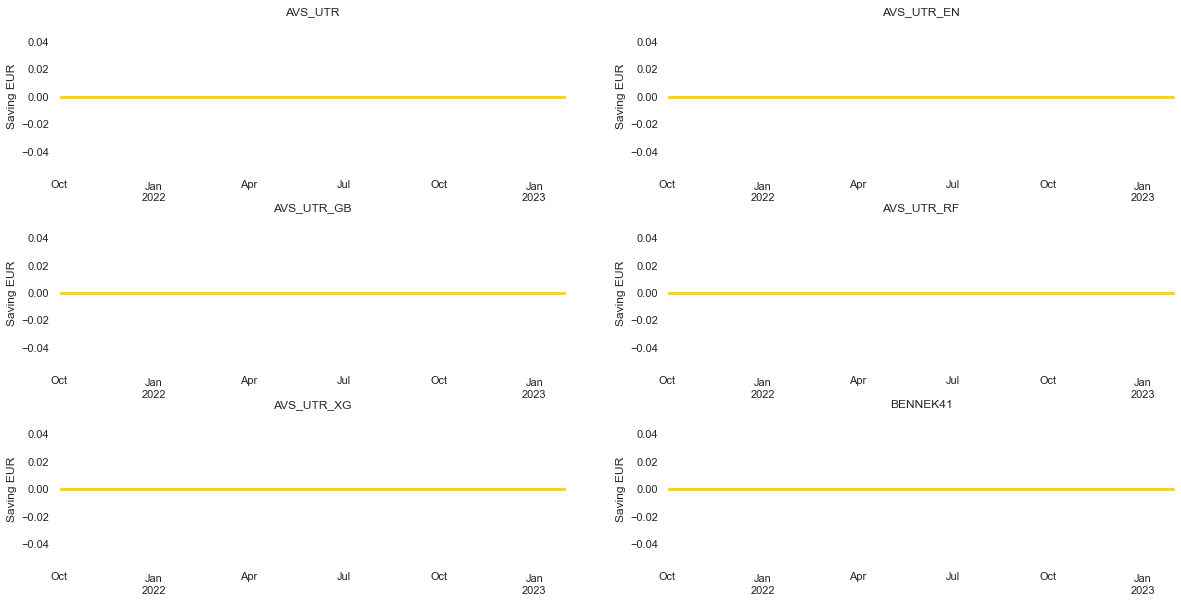

In [259]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.3)
for col, ax in zip(sorted(gas_use_sav.columns), axs.ravel()):
    index=gas_use_sav[col].index.get_loc(gas_use_sav[col].ne(0).idxmax())
    gas_use_sav[[col]].iloc[index:-1].plot(ax=ax, color='gold', linewidth=3) #excludes April for now, too early in the month to draw results
    ax.set_title(col.upper())
    ax.get_legend().remove()
    ax.set_ylabel("Saving EUR")

# Forecasting

In [235]:
#forecast periods are defined, which is - per building - SOC up until 31st of March 2022
forecast_periods=pd.DataFrame()
forecast_periods['start'] = socs[gas_eans.index]
forecast_periods['end'] = pd.Timestamp('2022-03-31')
forecast_periods=forecast_periods[~forecast_periods.index.duplicated(keep='first')]
forecast_periods

,start,end
AVS_UTR,2021-10-19,2022-03-31
BENNEK41,2021-10-21,2022-03-31
DIEMEN,2021-10-26,2022-03-31
P163063,2021-12-21,2022-03-31


In [236]:
engine = Engine(project=project, isAsync=False)
time_res = 'd'
gas_use_train = pd.DataFrame(index=pd.date_range(start=forecast_periods['start'].min(),
                                                 end=forecast_periods['end'].max(),
                                                 freq=time_res))

# data from sp-ql
for building in gas_eans.index:
    # get gas use
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']
    gas_ean = gas_eans[building]
    gas_use = engine.select(gas_ean).group_by(time_res).sum().after(start_train).before(end_train).all()
    gas_use = gas_use.rename(columns={gas_use.columns[0]:building})
    gas_use_train = gas_use_train.join(gas_use)
gas_use_train.to_csv(r'NSI_gas/data/gas_use_train_f.csv')

In [237]:
gas_use_train = pd.read_csv(r'NSI_gas/data/gas_use_train_f.csv', index_col=0,
                            parse_dates=True)
# some buildings have small gaps in gas data. We can interpolate over these
for building in gas_eans.index:
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']
    gas_use_train_build = gas_use_train.loc[start_train:end_train, building]
    # setting first element to 0 if nan. To aid interpolation.
    if gas_use_train_build.iloc[[0]].isna()[0]:
        gas_use_train_build.iloc[0] = 0
    gas_use_train_build = gas_use_train_build.interpolate(limit=10) # filling max 10 consecutive days of missing data
    gas_use_train.loc[start_train:end_train, building] = gas_use_train_build
gas_use_train

,AVS_UTR,BENNEK41,DIEMEN,P163063
2021-10-19,53.569901,NaN,NaN,NaN
2021-10-20,54.102100,NaN,NaN,NaN
2021-10-21,128.668106,101.114899,NaN,NaN
2021-10-22,136.098694,143.729904,NaN,NaN
2021-10-23,0.000000,2.811500,NaN,NaN
...,...,...,...,...
2022-03-27,36.329102,0.000000,4.920300,25.805901
2022-03-28,149.824997,135.827393,277.639709,171.704697
2022-03-29,142.274200,126.870796,253.139008,174.616898
2022-03-30,146.119705,126.258202,275.330200,260.871094


### Random Forest

In [238]:
for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
    del features['SQ'] #is only used for electricity
    features['dow'] = features.index.dayofweek
    
    gas_use_train_build = gas_use_train[building]
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]
    #
    # checking if there is any nan in the data
    if X.isna().sum().sum() + y.isna().sum() > 0:
        raise ValueError('NaN in training data:', building)
    #
    # checking on dependency of taget on features to get a feel
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    #
    # make train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #
    # grid-search for hyper parameter tuning
    param_grid = {'max_depth': [2, 5, 10, 20, 50, 100],
                  'min_samples_leaf': [1, 5, 10],
                  'n_estimators': [500]}
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False) # cv --> Kfold 10 with shuffle - because my data is in order (if I would randomize the order then this would not be necessary)
    grid_search.fit(X_train, y_train)
    #
    # save the trained RF
    joblib.dump(grid_search.best_estimator_, fr'NSI_gas/data/trained_models/f_rf/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_gas/data/trained_models/f_rf/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_gas/data/trained_models/f_rf/y_test_{building}.joblib')

Training building AVS_UTR, 1/4
Training building BENNEK41, 2/4
Training building DIEMEN, 3/4
Training building P163063, 4/4


### Gradient Boosting

In [239]:
for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans.index)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
    del features['SQ'] #is only used for electricity
    features['dow'] = features.index.dayofweek
    
    gas_use_train_build = gas_use_train[building]
    
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10],
    }

    rf = GradientBoostingRegressor()

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                        cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)

    joblib.dump(grid_search.best_estimator_, fr'NSI_gas/data/trained_models/f_gb/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_gas/data/trained_models/f_gb/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_gas/data/trained_models/f_gb/y_test_{building}.joblib')

Training building AVS_UTR, 1/4
Training building BENNEK41, 2/4
Training building DIEMEN, 3/4
Training building P163063, 4/4


### XGBoosting

In [240]:
for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
    del features['SQ'] #is only used for electricity
    features['dow'] = features.index.dayofweek
    
    gas_use_train_build = gas_use_train[building]
    
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    param_grid={
                "learning_rate": (0.05, 0.10, 0.15, 0.2),
                "max_depth": [3, 4, 5, 6, 8],
                "min_child_weight": [1, 3, 5, 7]
                }

    rf = XGBRegressor()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=cv, n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)

    joblib.dump(grid_search.best_estimator_, fr'NSI_gas/data/trained_models/f_xg/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_gas/data/trained_models/f_xg/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_gas/data/trained_models/f_xg/y_test_{building}.joblib')

Training building AVS_UTR, 1/4
Training building BENNEK41, 2/4
Training building DIEMEN, 3/4
Training building P163063, 4/4


### Predictions

In [241]:
warnings.filterwarnings("ignore")
gas_use_pred = pd.DataFrame(index=features.index)

for m in ['rf','gb','xg']:
    for building in gas_eans.index:
        
        city = cities[building]
        knmi_station = knmi_station_lookup[city]
        knmi_weather = weather[knmi_station]
        
        if knmi_station==240:
            features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
        if knmi_station==344:
            features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
        if knmi_station==370:
            features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
        if knmi_station==260:
            features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
        if knmi_station==275:
            features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)

        features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
        del features['SQ'] #is only used for electricity
        features['dow'] = features.index.dayofweek
        #features['month'] = features.index.month
        X_pred = features
        # do the predictions
        models = os.listdir(f'NSI_gas/data/trained_models/f_{m}')
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_gas/data/trained_models/f_{m}/trained_{building}.joblib')
        y_pred = grid_search.predict(X_pred)
        gas_use_pred[building+'_'+m] = y_pred

In [242]:
#ensemble stacking, equal weight
gas_use_pred['AVS_UTR_en']=(gas_use_pred['AVS_UTR_rf']+gas_use_pred['AVS_UTR_gb']+gas_use_pred['AVS_UTR_xg'])/3
gas_use_pred['BENNEK41_en']=(gas_use_pred['BENNEK41_rf']+gas_use_pred['BENNEK41_gb']+gas_use_pred['BENNEK41_xg'])/3
gas_use_pred['DIEMEN_en']=(gas_use_pred['DIEMEN_rf']+gas_use_pred['DIEMEN_gb']+gas_use_pred['DIEMEN_xg'])/3
gas_use_pred['P163063_en']=(gas_use_pred['P163063_rf']+gas_use_pred['P163063_gb']+gas_use_pred['P163063_xg'])/3

### Actual

In [243]:
# compare predicted and measured gas use after start of control
engine = Engine(project=project, isAsync=False)
time_res = 'd'
gas_use_meas = pd.DataFrame(index=pd.date_range(start=forecast_periods['start'].min(),
                                                end=knmi_weather.index[-49]+dt.timedelta(30),
                                                 freq=time_res))
for building in gas_eans.index:
    # get gas use
    start = train_periods['start'].min()
    end = knmi_weather.index[-1]+dt.timedelta(28)
    gas_ean = gas_eans[building]
    gas_use = engine.select(gas_ean).group_by(time_res).sum().after(start).before(end).all()
    gas_use = gas_use.rename(columns={gas_use.columns[0]:building})
    gas_use_meas = gas_use_meas.join(gas_use)

In [244]:
def calc_date_pos_on_plot(df_compare_monthly):
    soc=pd.Timestamp('2022-04-01 00:00:00')
    sm = list(df_compare_monthly.index < soc).index(False) # first False is start month
    return sm - 0.5 # place of dashed line on plot in 0-1 x coord range

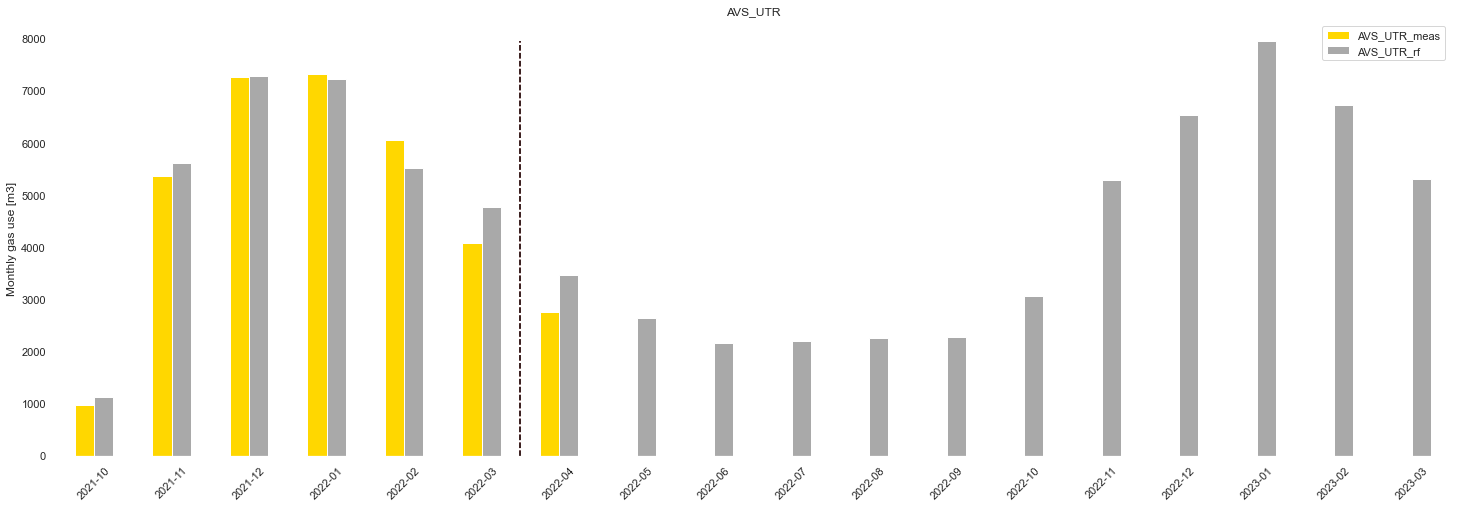

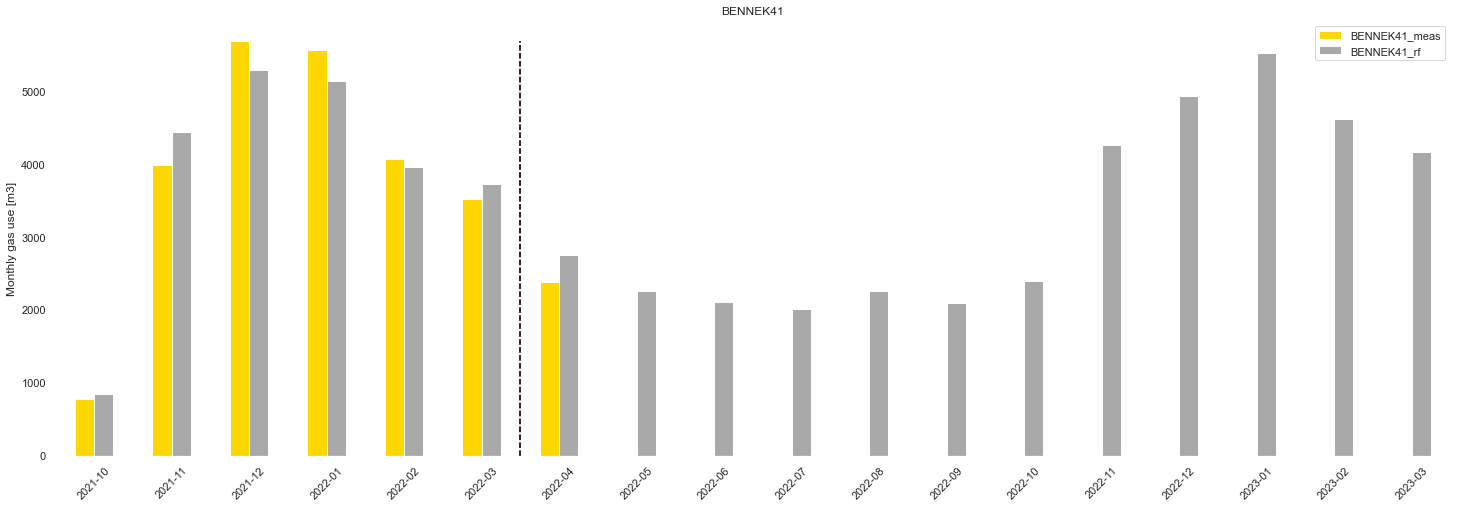

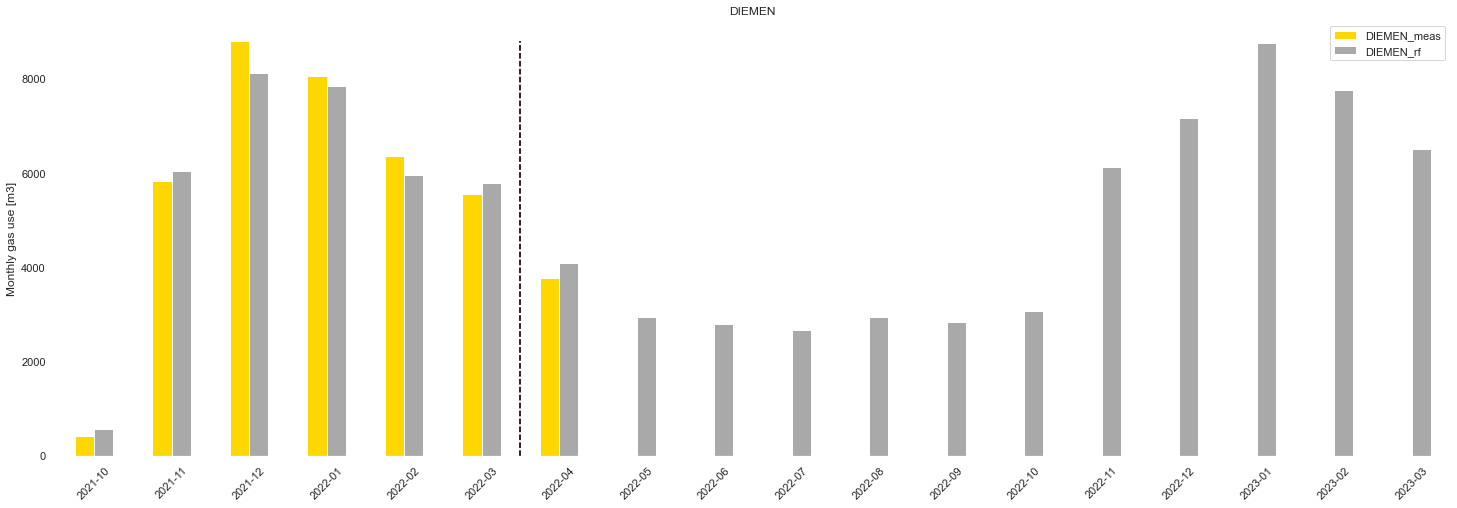

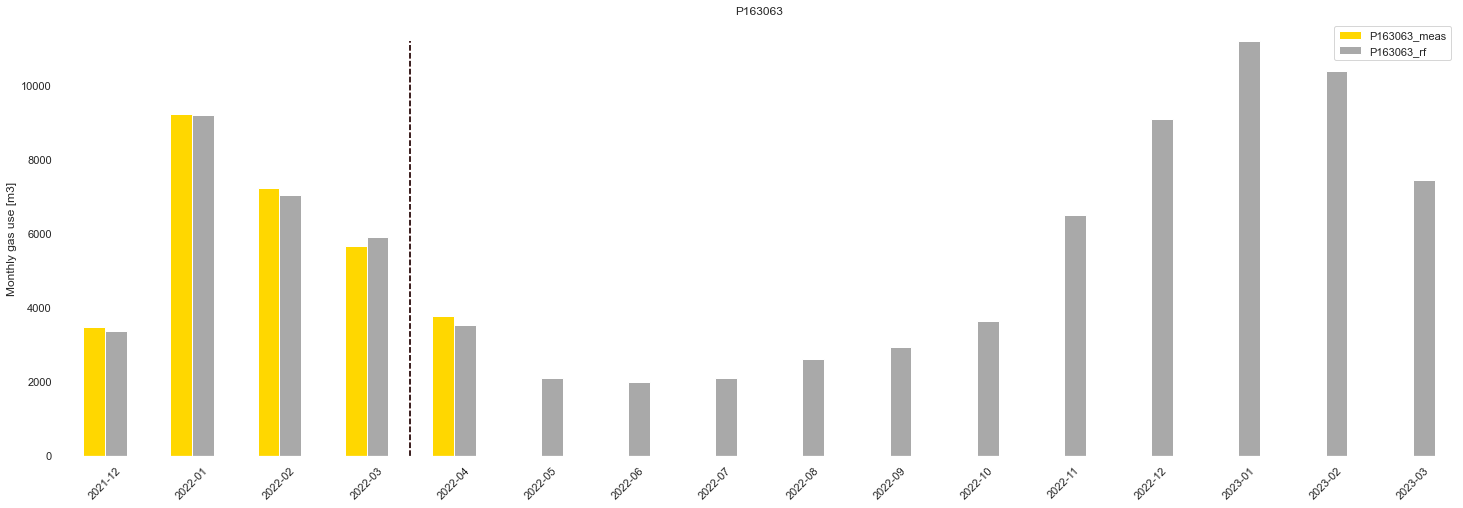

In [245]:
for building in gas_eans.index:
    start = forecast_periods.loc[building, 'start']
    end = gas_use_pred.index[-1]
    df_compare = pd.DataFrame(index=pd.date_range(start=start,
                                                     end=end,
                                                     freq=time_res))
    df_compare = df_compare.join(gas_use_meas[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    df_compare = df_compare.join(gas_use_pred[[building+"_rf"]])
    df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    #
    df_compare = df_compare.resample('m').sum()

    soc = socs[building]#.date()
    soc_pos = calc_date_pos_on_plot(df_compare_monthly=df_compare)
    train_end_pos = calc_date_pos_on_plot(df_compare_monthly=df_compare)
    #
    fig, ax = plt.subplots(figsize=(25, 8))
    df_compare.plot.bar(ax=ax, color=['gold', 'darkgray'])
    #soc_mark = pd.Series(index=df_compare.index, data=np.nan)
    ax.set_xticklabels([x.strftime("%Y-%m") for x in df_compare.index], rotation=45)
    plt.vlines(x=train_end_pos, ymin=0, ymax=df_compare.max().max(), color='darkred', ls='--')
    plt.vlines(x=soc_pos, ymin=0, ymax=df_compare.max().max(), color='k', ls='--')
    patches = ax.patches
    patches_m = patches[0:int(len(patches)/2)]
    patches_p = patches[int(len(patches)/2):]

    plt.ylabel('Monthly gas use [m3]')
    plt.title(building)
    plt.show(block=False)

In [246]:
metric_com_mae = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    mae_range_percent = pd.Series()
    for building in gas_eans.index:
        models = os.listdir(f'NSI_gas/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)

        #
        # calculating MAE and plotting test and pred_test
        mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
        # mae in percent of range
        mae_range_percent[building] = mae / y_test.max() * 100

        gas_use_train_build = gas_eans[building]

    metric_com_mae[regressor.upper()]=mae_range_percent

In [247]:
metric_com_rmse = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    rmse_range_percent = pd.Series()
    for building in gas_eans.index:
        models = os.listdir(f'NSI_gas/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)
        
        #calculating RMSE
        MSE = np.square(np.subtract(y_test, y_test_pred)).mean() 
        RMSE = math.sqrt(MSE)
        rmse_range_percent[building]=RMSE / y_test.max() * 100

    metric_com_rmse[regressor.upper()]=rmse_range_percent

In [248]:
en_mae = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
mae_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in gas_eans.index:
    for regressor in regressors:
        models = os.listdir(f'NSI_gas/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]

    mae = mean_absolute_error(y_true=df_c[building+"_en"], y_pred=df_d[building+"_en"])
    
    mae_range_percent[building] = mae / df_c[building+"_en"].max() * 100

    en_mae['EN']=mae_range_percent
    

### MAEs

In [249]:
metric_com_mae['EN']=en_mae
print(metric_com_mae)
print("\n")
print("Average MAEs")
round(metric_com_mae.mean(), 5)

                RF         GB         XG        EN
AVS_UTR   9.131083   9.806278  10.018636  6.649287
BENNEK41  6.236571   9.897578   6.952408  5.001619
DIEMEN    5.833690   9.087866   5.069853  4.667549
P163063   9.521163  11.250103   9.149704  8.813722


Average MAEs


RF     7.68063
GB    10.01046
XG     7.79765
EN     6.28304
dtype: float64

In [250]:
en_rmse = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
rmse_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in gas_eans.index:
    for regressor in regressors:
        models = os.listdir(f'NSI_gas/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_gas/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    

    MSE = np.square(np.subtract(df_c[building+"_en"], df_d[building+"_en"])).mean() 
    RMSE = math.sqrt(MSE)
    rmse_range_percent[building]=RMSE / df_c[building+"_en"].max() * 100
    
    en_rmse['EN']=rmse_range_percent
    

In [251]:
metric_com_rmse['EN']=en_rmse
print(metric_com_rmse)
print("\n")
print("Average RMSEs")
round(metric_com_rmse.mean(), 5)

                 RF         GB         XG         EN
AVS_UTR   13.837308  12.606663  13.595199   8.611364
BENNEK41   8.474636  11.215840   9.205389   6.209519
DIEMEN     8.691966  11.626956   7.714014   5.807554
P163063   12.477435  16.599180  13.435987  11.472145


Average RMSEs


RF    10.87034
GB    13.01216
XG    10.98765
EN     8.02515
dtype: float64

### Individual Predictions

In [334]:
gas_use_pred = pd.DataFrame(index=features.index)
for building in gas_eans.index:

    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)

    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
    del features['SQ'] #is only used for electricity
    features['dow'] = features.index.dayofweek
    #features['month'] = features.index.month
    X_pred = features
    # do the predictions
    models = os.listdir(f'NSI_gas/data/trained_models/f_xg')
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'NSI_gas/data/trained_models/f_xg/trained_{building}.joblib')
    y_pred = grid_search.predict(X_pred)
    gas_use_pred[building] = y_pred

In [337]:
gas_use_pred=gas_use_pred.loc['2022-04-01':,]
gas_use_pred=gas_use_pred.resample('m').sum()
gas_use_pred.mean()*0.87

AVS_UTR     3460.301025
BENNEK41    2862.519531
DIEMEN      4169.074219
P163063     4363.476074
dtype: float32